# CS4120 - Natural Language Processing - Spring 2024
## Instructor: Amir Tahmasebi

# Assignment 4 - Part I

## Text Classification Using TF-IDF and Logistic Regression

# Objective:
In this section, you will develop a text classification model using TF-IDF (Term Frequency-Inverse Document Frequency) for feature extraction and a Logistic Regression classifier for categorization. The goal is to understand how to process textual data, transform it into a suitable format for machine learning algorithms, and apply a classification model to predict the category of unseen documents.


In [93]:
# Import all necessary libraries
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import numpy as np
import pandas as pd
import re
import string

import matplotlib.pyplot as plt
%matplotlib inline

In [94]:
# load the data and learn insights about it
newsgroups = fetch_20newsgroups(subset='all')

print("Number of articles: " + str(len(newsgroups.data)))
print("Number of diffrent categories: " + str(len(newsgroups.target_names)))

newsgroups.target_names

Number of articles: 18846
Number of diffrent categories: 20


['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Each document is a text written in English in a form of an email with a lot of punctuations. You should always do some pre-processing but here we’ll just concentrate on the model.

In [95]:
# print sample data
print("\n".join(newsgroups.data[1121].split("\n")[:]))


From: et@teal.csn.org (Eric H. Taylor)
Subject: Re: Gravity waves, was: Predicting gravity wave quantization & Cosmic Noise
Summary: Dong ....  Dong ....  Do I hear the death-knell of relativity?
Keywords: space, curvature, nothing, tesla
Nntp-Posting-Host: teal.csn.org
Organization: 4-L Laboratories
Distribution: World
Expires: Wed, 28 Apr 1993 06:00:00 GMT
Lines: 30

In article <C4KvJF.4qo@well.sf.ca.us> metares@well.sf.ca.us (Tom Van Flandern) writes:
>crb7q@kelvin.seas.Virginia.EDU (Cameron Randale Bass) writes:
>> Bruce.Scott@launchpad.unc.edu (Bruce Scott) writes:
>>> "Existence" is undefined unless it is synonymous with "observable" in
>>> physics.
>> [crb] Dong ....  Dong ....  Dong ....  Do I hear the death-knell of
>> string theory?
>
>     I agree.  You can add "dark matter" and quarks and a lot of other
>unobservable, purely theoretical constructs in physics to that list,
>including the omni-present "black holes."
>
>     Will Bruce argue that their existence can be inferre

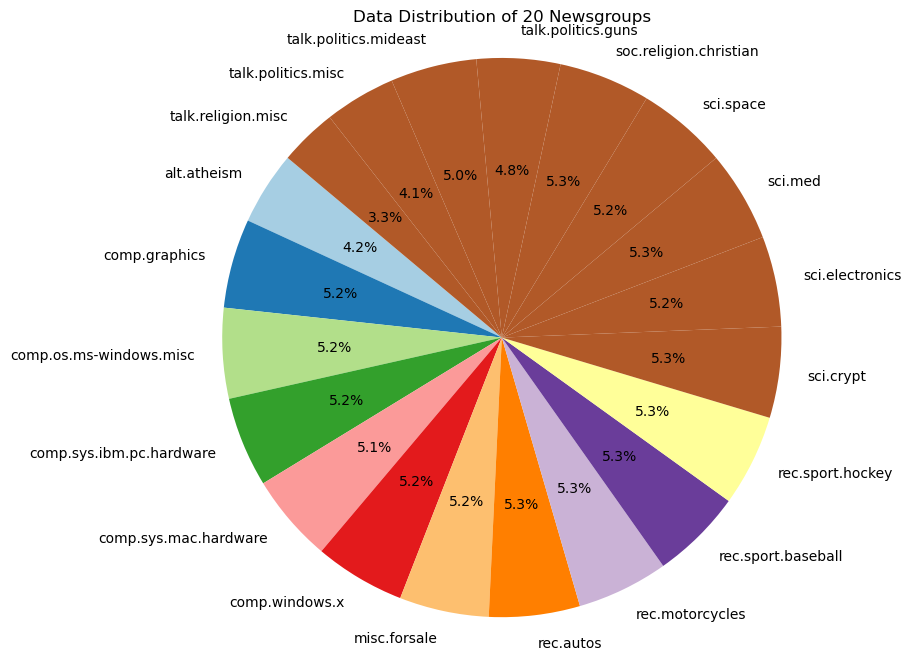

In [96]:
# Count the number of documents in each category
category_counts = dict(zip(newsgroups.target_names, [0] * len(newsgroups.target_names)))
for target in newsgroups.target:
    category_counts[newsgroups.target_names[target]] += 1

# Data to plot
labels = list(category_counts.keys())
sizes = list(category_counts.values())
colors = plt.cm.Paired(range(len(labels)))

# Plot
plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Data Distribution of 20 Newsgroups')
plt.show()

## Load Training Set from NewsGroups Dataset

In [97]:
#Loading the training data.
mydata_train = fetch_20newsgroups(subset='train', shuffle=True, remove = ('headers', 'footers', 'quotes'))
print('Training data size:', len(mydata_train['data']))

Training data size: 11314


## Load Test Set from NewsGroup Dataset

In [98]:
#Loading the test data.
mydata_test = fetch_20newsgroups(subset='test', shuffle=True, remove = ('headers', 'footers', 'quotes'))
print('Test data size:', len(mydata_test['data']))

Test data size: 7532


## Data Preparation:
You need to perform preparation steps such as Tokenization, Convert everything to lowercase, Removing stopwords, Stemming, Lemmatizing, and converting text data to a vector representation.

It is easier if you store your data in dataframe but not necessarily needed.

In [99]:
# you can store the data in dataframe for easier processing
mydata_train_df = pd.DataFrame({'data': mydata_train.data, 'target': mydata_train.target})

In [100]:
# Preparing test data accordingly
mydata_test_df = pd.DataFrame({'data': mydata_test.data, 'target': mydata_test.target})
mydata_test_df.head()

,data,target
0,I am a little confused on all of the models of...,7
1,I'm not familiar at all with the format of the...,5
2,"\nIn a word, yes.\n",0
3,\nThey were attacking the Iraqis to drive them...,17
4,\nI've just spent two solid months arguing tha...,19


In [101]:
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
# <<<<    Add code  here    >>>>
# Suggestions: Text preprocessing steps - remove numbers, captial letters and punctuation
# apply preprocessing to both training and test sets
# lets assume you store preprocessed data in: 
# mydata_train_df['preproc']
# mydata_test_df['preproc']

def process_data(df_words):
    tokens = []
    stop_words = set(stopwords.words('english'))
    for i in range(len(df_words)):
        words = re.sub(r'[\d.,!.:;]', '', df_words["data"][i]).lower()
        word_tokens = nltk.word_tokenize(words)
        rem_stop_words = [word for word in word_tokens if word not in stop_words]
        final_words = ' '.join(rem_stop_words)
        tokens.append(final_words)
    return tokens
mydata_train_df['preproc'] = process_data(mydata_train_df)
mydata_test_df['preproc'] = process_data(mydata_test_df)
print(mydata_train_df['preproc'].shape)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rahul.muthuswamy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rahul.muthuswamy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


(11314,)


In [102]:
mydata_train_df['preproc'][0]

'wondering anyone could enlighten car saw day -door sports car looked late s/ early called bricklin doors really small addition front bumper separate rest body know anyone tellme model name engine specs years production car made history whatever info funky looking car please e-mail'

## TF-IDF Vectorization
Implement TF-IDF here. You can use sklearn.

In [103]:
# <<<<    Add code  here    >>>>
from sklearn.feature_extraction.text import TfidfVectorizer
tf_vectorizor = TfidfVectorizer()
tf_vectorizor.fit(mydata_train_df['preproc'])
X_train = tf_vectorizor.transform(mydata_train_df['preproc'])
X_test = tf_vectorizor.transform(mydata_test_df['preproc'])
X_train.toarray().shape


(11314, 88071)

## Logistic Regression Classifier
Implement LR classifier here. You can use sklearn.

In [104]:
# <<<<    Add code  here    >>>>
from sklearn.linear_model import LogisticRegression
LR_Classifier = LogisticRegression()
y_train = mydata_train_df['target'].values
LR_Classifier.fit(X_train.toarray(), y_train)


LogisticRegression()

In [105]:
from sklearn.metrics import precision_score, recall_score, f1_score
y_pred = LR_Classifier.predict(X_test)
print("Accuracy: " + str(LR_Classifier.score(X_test, mydata_test_df.target)))
print("Precision: " + str(np.round(precision_score(mydata_test_df.target, y_pred, average=None), 2)))
print("Recall: " + str(np.round(recall_score(mydata_test_df.target, y_pred, average=None), 2)))
print("F1-Score: " + str(np.round(f1_score(mydata_test_df.target, y_pred, average=None), 2)))

Accuracy: 0.683749336165693
Precision: [0.49 0.6  0.67 0.66 0.75 0.81 0.74 0.75 0.48 0.83 0.9  0.87 0.54 0.77
 0.71 0.64 0.59 0.86 0.57 0.51]
Recall: [0.46 0.69 0.62 0.64 0.68 0.72 0.78 0.71 0.82 0.8  0.86 0.66 0.6  0.78
 0.75 0.79 0.68 0.73 0.45 0.19]
F1-Score: [0.47 0.64 0.64 0.65 0.71 0.76 0.76 0.73 0.61 0.81 0.88 0.75 0.57 0.77
 0.73 0.71 0.63 0.79 0.5  0.27]


## Confusion Matrix
A confusion matrix is a table used in machine learning for evaluating the performance of a classification algorithm. It is particularly useful for understanding how well a model is performing in terms of correctly and incorrectly classifying instances across different categories. 

In multi-class classification scenarios, the confusion matrix helps identify specific classes that may be more challenging for the model to predict and how classes are confused with one another. Each row of the matrix represents the instances in an actual class, while each column represents the instances in a predicted class. 

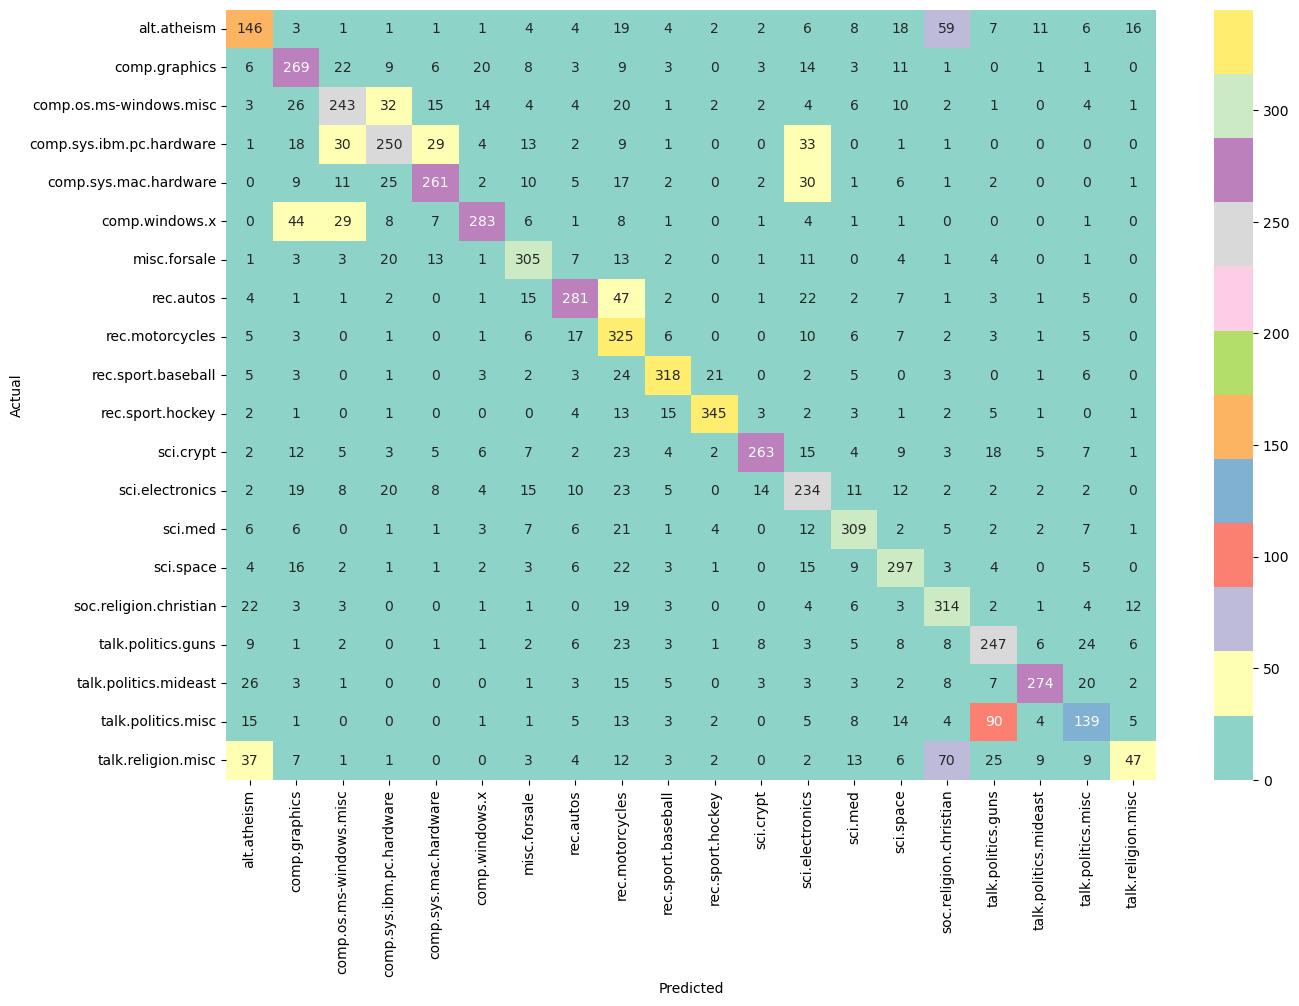

In [106]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# store predictions on test set in y_pred
y_pred = LR_Classifier.predict(X_test)

# calculate confusion matrix using built-in functionality in sklearn
conf_mat = confusion_matrix(mydata_test_df.target, y_pred)

# Plot confusion_matrix
fig, ax = plt.subplots(figsize=(15, 10))

# remember labels = list(category_counts.keys())
sns.heatmap(conf_mat, annot=True, cmap = "Set3", fmt ="d", xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()